In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Loading the train.csv file into the notebook
train_data = pd.read_csv("./train.csv")

# Outputs the first five rows of the table in train.csv
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Loading the test.csv file into the notebook
test_data = pd.read_csv("./test.csv")

# Outputs the first five rows of the table in test.csv
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Titanic Logistic Regression Model

## Training

In [5]:
# Replaces nans with the most used value
train_data.fillna({col: train_data[col].mode()[0] for col in ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked']}, inplace=True)
test_data.fillna({col: test_data[col].mode()[0] for col in ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked']}, inplace=True)

# Replaces nans with the average used value
train_data.fillna({col: train_data[col].mean() for col in ['Age']}, inplace=True)
test_data.fillna({col: test_data[col].mean() for col in ['Age']}, inplace=True)

# Replaces strings with binary that can be used to compare 
train_data = pd.get_dummies(train_data, columns=["Sex", 'Embarked'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=["Sex", 'Embarked'], drop_first=True)

# Remove unnecessary columns/ preparing training and test data
X_train = train_data.drop(columns=["PassengerId", "Name", "Ticket", "Fare", "Cabin", "Survived"])
Y_train = train_data["Survived"]
X_test = test_data.drop(columns=["PassengerId", "Name", "Ticket", "Fare", "Cabin"])

# Transpose to match features and labels
X_train = np.array(X_train).T
Y_train = np.array(Y_train).reshape(1, -1)
X_test = np.array(X_test).T

# Making sure shapes are correct
print()
print('X_train shape {}'.format(X_train.shape))
print('Y_train shape {}'.format(Y_train.shape))
print('X_test shape {}'.format(X_test.shape))


X_train shape (7, 891)
Y_train shape (1, 891)
X_test shape (7, 418)


In [6]:
# Sigmoid function
def sigmoid(z):
    e = math.e
    a = 1/(1 + e**(-z))
    return a

In [7]:
# Initializing Parameters
def init_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0.0
    return w, b

In [8]:
# Forward and Backward Propagation
def forward_backward(X, Y, w, b):
    m = X.shape[1]

    # Forward    
    w = np.array(w) # Make sure w is a np array
    
    A = sigmoid(w.T @ X + b)        
    
    A = A.astype(np.float64) # Make sure correct values for log calculation 
    
    cost = -(1/m) * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))

    # Backward
    dZ = A - Y
    dw = (1/m) * X @ np.transpose(dZ)
    db = (1/m) * np.sum(dZ)

    cost = np.squeeze(cost)
    grads = {'dw': dw, 'db': db}
    
    return grads, cost

In [9]:
# Gradient Descent
def gradient_descent(X, Y, w, b, num_iters, alpha, verbose=False):
    costs = []
    m = X.shape[1]
    
    for i in range(num_iters):
        grads, cost = forward_backward(X, Y, w, b)

        dw = grads['dw']
        db = grads['db']

        w = w - alpha * dw
        b = b - alpha * db

        if i % 100 == 0:
            costs.append(cost)
        if i % 100 == 0 and verbose:
            print("Cost after iter {}: {}".format(i, cost))
        
    params = {'w': w, 'b': b}
        
    return params, costs

In [10]:
# Predict
def predict(X, w, b):
    m = X.shape[1]
    Y_pred = np.zeros((1, m))

    w = np.array(w).reshape(-1, 1)
    X = np.array(X, dtype=np.float64)
    
    A = sigmoid(w.T @ X + b)

    for i in range(A.shape[1]):
        Y_pred[0, i] = 1 if A[0][i] > 0.5 else 0
    
    return Y_pred

In [11]:
# Putting it together for the model
def model(X_train, Y_train, X_test, num_iters=1000, alpha=0.01, verbose=False):
    w, b = init_zeros(X_train.shape[0])
    params, costs = gradient_descent(X_train, Y_train, w, b, num_iters, alpha, verbose)
    
    w = params['w']
    b = params['b']
    
    Y_pred_train = predict(X_train, w, b)
    Y_pred_test = predict(X_test, w, b)
    
    result = {
        'w': w,
        'b': b,
        'costs': costs,
        'Y_pred_test': Y_pred_test
    }
    
    return result

In [12]:
# Evaluating
result = model(X_train, Y_train, X_test, num_iters=10000, alpha=0.01, verbose=True)

Cost after iter 0: 0.6931471805599454
Cost after iter 100: 0.7431667741064382
Cost after iter 200: 0.7302308626534412
Cost after iter 300: 0.7189936824691907
Cost after iter 400: 0.7084669938110508
Cost after iter 500: 0.6983434174378965
Cost after iter 600: 0.6885360735052252
Cost after iter 700: 0.6790272985331852
Cost after iter 800: 0.6698183634920233
Cost after iter 900: 0.660912815510311
Cost after iter 1000: 0.6523113587359509
Cost after iter 1100: 0.6440108195759461
Cost after iter 1200: 0.6360045621687562
Cost after iter 1300: 0.6282833580804436
Cost after iter 1400: 0.6208363070443639
Cost after iter 1500: 0.613651644378213
Cost after iter 1600: 0.6067173788948262
Cost after iter 1700: 0.6000217572033617
Cost after iter 1800: 0.593553574285501
Cost after iter 1900: 0.5873023590523644
Cost after iter 2000: 0.5812584643704067
Cost after iter 2100: 0.5754130879945407
Cost after iter 2200: 0.5697582463976547
Cost after iter 2300: 0.5642867189530021
Cost after iter 2400: 0.5589919

## Testing and Visualization

In [14]:
# Creating submission dataframe
submission_data = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': result['Y_pred_test'].astype(int).flatten()
})

# Saving submission dataframe as submission csv
submission_data.to_csv('submission.csv', index=False)

print()
print("Submitted Submission file\n")
print(submission_data)


Submitted Submission file

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]


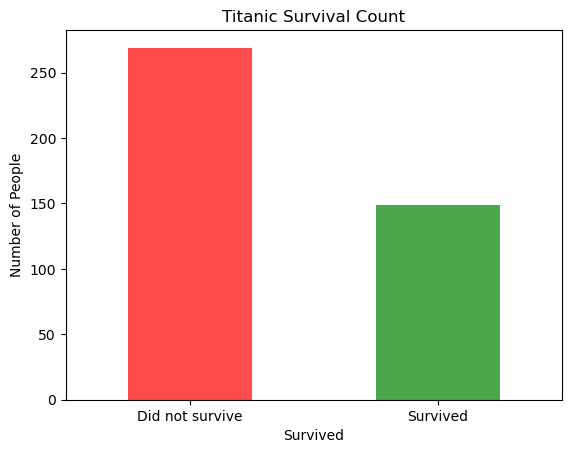

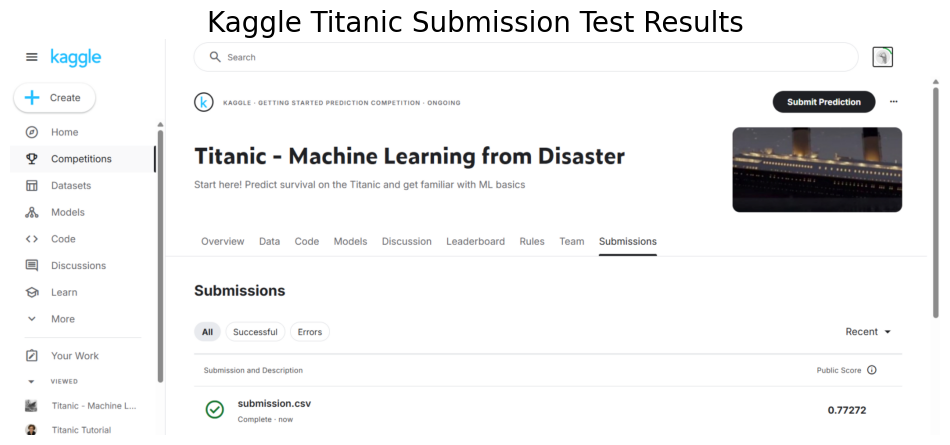

In [15]:
# Counts how many survived or not for each passenger
survival_counts = submission_data['Survived'].value_counts()

# Plotting the counts in a bar chart
survival_counts.plot(kind='bar', color=['red', 'green'], alpha=0.7)
plt.xticks([0, 1], ['Did not survive', 'Survived'], rotation=0)
plt.ylabel('Number of People')
plt.title('Titanic Survival Count')
plt.show()

print()

# Plotting the kaggle submission screenshot
submission_img = mpimg.imread('results.png')
plt.figure(figsize=(12, 8))
plt.title('Kaggle Titanic Submission Test Results', fontsize=20)
plt.imshow(submission_img)
plt.axis('off')
plt.show()